In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class GaussianDataset(Dataset):
    def __init__(self, size=1000, dimensions=10):
        """
        Initialize the dataset.
        :param size: Number of samples in the dataset.
        """
        self.size = size
        self.dimensions = dimensions

    def __len__(self):
        """
        Return the size of the dataset.
        """
        return self.size

    def __getitem__(self, idx):
        """
        Generate and return a single sample from the dataset at the given index.
        Here, x is sampled from a unit Gaussian distribution.
        """
        x = np.random.normal()  # Sample x from a unit Gaussian distribution
        data = x * np.ones(self.dimensions)  # Multiply x by an array of ones
        return torch.tensor(data, dtype=torch.float)  # Convert to a PyTorch tensor and return

# Example usage
dataset = GaussianDataset(size=100)  # Create an instance of the dataset
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)  # Create a DataLoader

# Iterate over the DataLoader
# for data in dataloader:
#     print(data)
#     break  # Just print the first batch and break


/home/zihao/anaconda3/envs/diff/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [50]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.interpolate import CubicSpline

class CubicSplineDataset(Dataset):
    def __init__(self, size=1000, dimensions=10):
        """
        Initialize the dataset.
        :param size: Number of samples in the dataset.
        :param dimensions: Number of dimensions for each sample.
        """
        self.size = size
        self.dimensions = dimensions
        self.x = np.linspace(0, 1, dimensions)  # Define the x-axis for the spline
        self.base_points_x = np.linspace(0, 1, 5)  # 5 points to define the spline

    def __len__(self):
        """
        Return the size of the dataset.
        """
        return self.size

    def __getitem__(self, idx):
        """
        Generate and return a single sample from the dataset at the given index.
        For each sample, generate a unique set of base_points_y to define the cubic spline,
        then evaluate the spline, and normalize the data by a weight a.
        """
        # Generate a unique set of y values for the cubic spline for each sample
        base_points_y = np.random.randn(5)  # Random y values for the spline

        # Create a cubic spline based on the unique base points for this sample
        spline = CubicSpline(self.base_points_x, base_points_y)

        # Evaluate the spline to generate data
        y = spline(self.x)

        # Sample weight a from a unit Gaussian distribution
        # a = np.random.normal()
        a = 1

        # Normalize the data by the weight a
        normalized_data = a * y

        return torch.tensor(normalized_data, dtype=torch.float)  # Convert to a PyTorch tensor and return

# Example usage
dataset = CubicSplineDataset(size=1000, dimensions=10)  # Create an instance of the dataset
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)  # Create a DataLoader


In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.interpolate import CubicSpline

class BiasedCubicSplineDataset(Dataset):
    def __init__(self, size=1000, dimensions=10):
        """
        Initialize the dataset.
        :param size: Number of samples in the dataset.
        :param dimensions: Number of dimensions for each sample.
        """
        self.size = size
        self.dimensions = dimensions
        self.x = np.linspace(0, 1, dimensions)  # Define the x-axis for the spline

    def __len__(self):
        """
        Return the size of the dataset.
        """
        return self.size

    def __getitem__(self, idx):
        """
        Generate and return a single sample from the dataset at the given index.
        Each sample has its unique cubic spline based on random y values and is biased towards one of the two modes.
        """
        mode = np.random.choice([-1, 1])  # Uniformly select a mode
        base_points_x = np.linspace(0, 1, 5)  # x positions for base points remain constant
        base_points_y = np.random.rand(5)  # Random y values for the spline, unique for each sample
        
        # Create a cubic spline for this sample
        spline = CubicSpline(base_points_x, base_points_y)
        y = spline(self.x)  # Evaluate the spline
        
        a = np.random.normal()  # Sample weight a from a unit Gaussian distribution
        normalized_data = a * y + mode  # Normalize and bias the data
        
        return torch.tensor(normalized_data, dtype=torch.float)  # Convert to a PyTorch tensor and return

# Example usage
dataset = BiasedCubicSplineDataset(size=1000, dimensions=10)  # Create an instance of the dataset
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)  # Create a DataLoader


In [4]:
batch = next(iter(dataloader))
print(batch.shape)

torch.Size([10, 10])


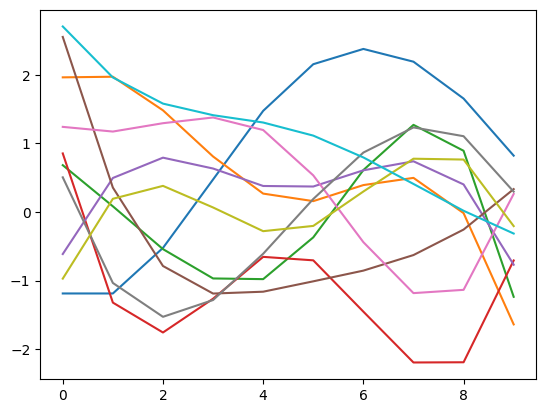

In [55]:
for data in dataloader:
    samples = data.numpy()  # Convert to numpy array

    # Plot the samples
    import matplotlib.pyplot as plt
    for sample in samples:
        plt.plot(sample)
    plt.savefig('samples.png')
    plt.show()
    break  # Just plot the first batch and break


samples: (1000, 10)
samples_reshaped: (10000, 1)


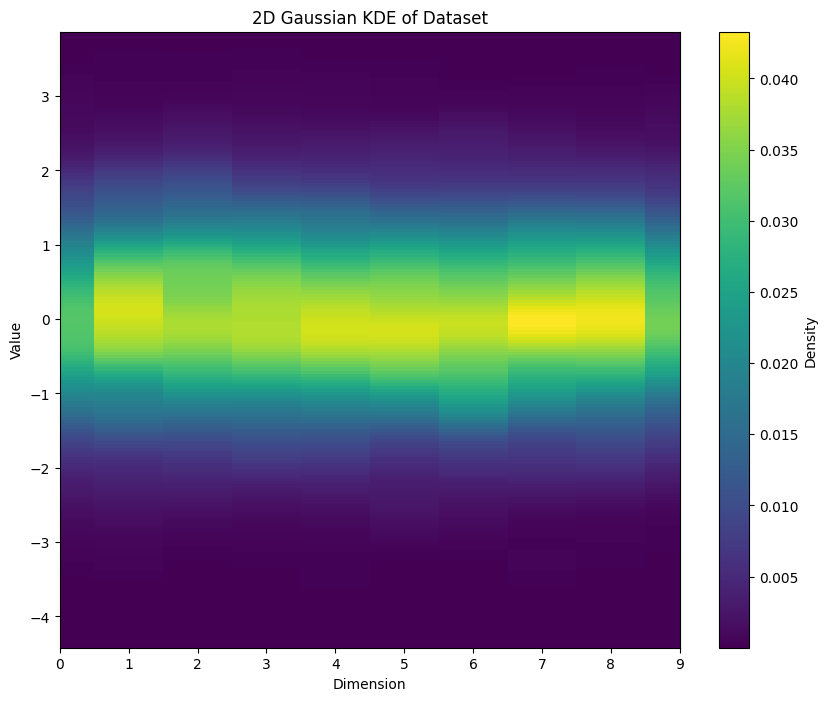

In [56]:

from scipy.stats import gaussian_kde

# Create an instance of the dataset and DataLoader

# dataset = GaussianDataset(size=1000)
dataset = CubicSplineDataset(size=1000, dimensions=10)  # Create an instance of the dataset
# dataset = BiasedCubicSplineDataset(size=1000, dimensions=10)  # Create an instance of the dataset

dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)

# Load the entire dataset into a NumPy array
for data in dataloader:
    samples = data.numpy()  # Convert to numpy array


# Reshape data to fit the (samples, dimensions) format for KDE
samples_reshaped = samples.reshape(-1, 1)  # Reshape to a 2D array for KDE
dimensions = np.repeat(np.arange(10), 1000).reshape(-1, 1)  # Repeat each dimension 1000 times

print('samples:', samples.shape)
print('samples_reshaped:', samples_reshaped.shape)

# Combine samples and dimensions for KDE input
kde_input = np.hstack((dimensions, samples_reshaped))


# '''
# Create a gaussian_kde object
kde = gaussian_kde(kde_input.T)

# Create a grid of points for evaluating the KDE
dim_grid = np.repeat(np.arange(10), 10)
value_grid = np.linspace(samples.min(), samples.max(), 200)
dim_grid, value_grid = np.meshgrid(dim_grid, value_grid)
kde_grid = np.vstack([dim_grid.ravel(), value_grid.ravel()])

# Evaluate the KDE on the grid
Z = kde(kde_grid).reshape(dim_grid.shape)

# Plot the result using pcolormesh
plt.figure(figsize=(10, 8))
plt.pcolormesh(dim_grid, value_grid, Z, shading='auto')
plt.colorbar(label='Density')
plt.xlabel('Dimension')
plt.ylabel('Value')
plt.title('2D Gaussian KDE of Dataset')
plt.savefig('kde.png')
plt.show()
# '''

(2, 1000)


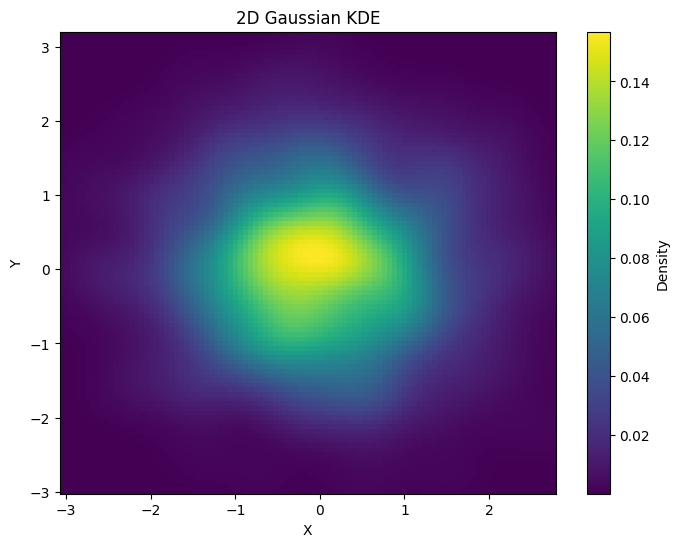

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Generate random 2D data
np.random.seed(0) # For reproducibility
x = np.random.normal(size=1000)
y = np.random.normal(size=1000)
data = np.vstack([x, y])

print(data.shape)

# Create a gaussian_kde object
kde = gaussian_kde(data)

# Create a grid of points where we want to evaluate the KDE
xgrid = np.linspace(x.min(), x.max(), 100)
ygrid = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(xgrid, ygrid)

# Evaluate the KDE on the grid
Z = kde(np.vstack([X.ravel(), Y.ravel()]))

# Reshape the result back into a 2D array
Z = np.reshape(Z, X.shape)

# Plot the result using pcolormesh
plt.figure(figsize=(8, 6))
plt.pcolormesh(X, Y, Z, shading='auto')
plt.colorbar(label='Density')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Gaussian KDE')
plt.show()
